April 15 2021

1) simulate brownian motion on three bounded axes (H 0-1, S 0-1, V 0-1). Note that hue boundaries are "pacman" so that red is neighbors with blue as well as yellos 
2) visualize this motion through time.
3) add: animation of process
4) add: birthdeath process
5) add: evolution along a tree

In [73]:
from math import sqrt
from scipy.stats import norm
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt

def cumsum_pacman(values, ub=1, lb=0):
    ##check to make sure inital position falls within bounds
    try:
        values[0] >= lb and values[0] <= ub
    except:
        print("inital value of {} outside start range".format(values[0]))
        
    max_disp = ub-lb #maximum possible displacement through space
    delta_u = abs(ub - values[0]) # distance to upper and lower boundaries from initial step 
    delta_b = abs(lb - values[0])
    cumsum_values = []
    prior_disp, final_disp = 0,0
    
    for ii, jj in np.ndenumerate(values):
        delta_u = ub - prior_disp
        #print("ub is {} prior_disp is {}, delta_u is {}".format(ub, prior_disp, delta_u))
        delta_l = abs(prior_disp - lb)
        #print("lb is {} prior_disp is {}, delta_l is {}".format(lb, prior_disp, delta_l))
        unbounded_disp = prior_disp + jj #start disp + jj bounded_sum+jj
        if unbounded_disp <= ub and unbounded_disp >= lb: 
            final_disp = unbounded_disp
            #print("in between: final disp is {}".format(final_disp))
        elif unbounded_disp > ub:
            excess = unbounded_disp - ub
            #print("{} exceeds ub by {}".format(unbounded_disp, excess))
            while excess > max_disp: # while the remaining displacement is large, bounce back and forth between boundaries
                excess = excess - max_disp
            final_disp = excess
            #print("final {} =  excess {} = lb {}".format(final_disp, excess, lb))
        elif unbounded_disp < lb:
            excess = lb - unbounded_disp 
            #print("{} exceeds lb by {}".format(unbounded_disp, excess))
            while excess > max_disp: # while the remaining displacement is large, bounce back and forth between boundaries
                excess = excess - max_disp
            final_disp = ub - excess 
            #print("final {} = ub {} - excess".format(final_disp, ub, excess))
        
        cumsum_values.append(final_disp)
        prior_disp = final_disp
    return cumsum_values        
            
def cumsum_with_limits(values, ub=1, lb=0):
    ##takes a vector of steps under bm and calculates displacement assuming that boundaries reflect
    max_disp = ub-lb #maximum possible displacement through space
    delta_u = abs(ub - values[0]) # distance to upper and lower boundaries from initial step 
    delta_b = abs(lb - values[0])
    cumsum_values = []
    prior_disp, final_disp = 0,0
    
    def getDisp(reflect_disp, direction):
        # if headed towards ub, add disp to lb
        #if headed towards lb then subtract disp from ub
        if direction > 0: 
            disp = lb + reflect_disp
        else:
            disp = ub - reflect_disp
        return disp
     
    for ii, jj in np.ndenumerate(values):
#         print("type ub is {} type jj is {}".format(type(ub), type(jj)))
#         print("ub is {} jj is {}".format((ub), (jj)))
        delta_u = ub - prior_disp
        #print("ub is {} prior_disp is {}, delta_u is {}".format(ub, prior_disp, delta_u))
        delta_l = abs(prior_disp - lb)
        #print("lb is {} prior_disp is {}, delta_l is {}".format(lb, prior_disp, delta_l))
        unbounded_disp = prior_disp + jj #start disp + jj bounded_sum+jj
        if unbounded_disp <= ub and unbounded_disp >= lb: 
            final_disp = unbounded_disp
            #print("in between: final disp is {}".format(final_disp))
        elif unbounded_disp > ub:
            #print("unbounded_disp is {} which is greater than ub of {}".format(unbounded_disp, ub))
            reflect_disp = unbounded_disp - ub #anything in excess of ub gets reflected
            #print("unbound_disp: {}, delta_u: {}, reflect_disp: {}".format(unbounded_disp, delta_u, reflect_disp))
            direction = -1 # meaning that disp heads towards lb
            while reflect_disp > max_disp: # while the remaining displacement is large, bounce back and forth between boundaries
                reflect_disp = reflect_disp - max_disp
                direction = direction * -1 # bounce off boundary and change direction
            final_disp = getDisp(reflect_disp, direction)
            #print("\nfinal {} = reflect_disp".format(final_disp, reflect_disp))
        elif unbounded_disp < lb:
            #print("unbounded_disp: {}, lb: {}, delta_l: {} ".format(unbounded_disp, lb, delta_l))
            direction = 1 # move towards ub
            reflect_disp = abs(unbounded_disp) - abs(lb)
            #print("reflected displacement is {}".format(reflect_disp))
            while reflect_disp > max_disp:
                reflect_disp = reflect_disp - max_disp
                direction = direction * -1
            final_disp = getDisp(reflect_disp, direction)
            #print("\nfinal {} = reflect_disp".format(final_disp, reflect_disp))
        cumsum_values.append(final_disp)
        prior_disp = final_disp
    return cumsum_values

def getStartVals(reps):
    svals = np.random.uniform(size = (reps,3))
    res = np.apply_along_axis(colors.is_color_like, 1, svals)
    if not (all(res)):
        print("{} is not a color like object. Trying again".format(res))
        getStartVals(reps)
    else:
        return svals
    
def getHSVSteps(steps, sigmasq=1, reps=1, startColor = None):
    #starting from a single color
    if not startColor.any():
        svals = np.array([0., 0., 0.])
        #svals = np.array([0., 1., 1.]) # hsv for red
        svals = np.repeat(svals, reps )
        #svals = getStartVals(reps)
    else:
        svals = startColor
        svals = np.repeat(svals, reps )
        
    disps = norm.rvs(size=svals.shape + (steps,), scale=np.sqrt(sigmasq))
    tdisp = np.column_stack((svals, disps))
    hh = cumsum_pacman(tdisp[0])
    ss = cumsum_with_limits(tdisp[1])
    vv = cumsum_with_limits(tdisp[2])
    difcolors = np.array([hh,ss,vv])
    return(difcolors, tdisp)  

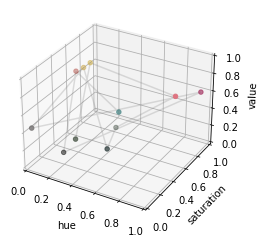

In [74]:
# disps, svals = getHSVSteps(2, sigmasq = 0.01,startColor=np.array([1., 1., 1.]))
# hh = cumsum_pacman(disps[0])
# ss = cumsum_with_limits(disps[1])
# vv = cumsum_with_limits(disps[2])
res, disps = getHSVSteps(10,startColor=np.array([0.5, 0.5, 0.5]))
#colorcoordinates = np.array([hh,ss,vv])
colorcoordinates=res.transpose()
rgb = colors.hsv_to_rgb(colorcoordinates)
# C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(res[0], res[1], res[2], c = rgb)
ax.plot3D(res[0], res[1], res[2], 'grey', alpha = 0.25)
ax.set_xlabel('hue')
ax.set_ylabel('saturation')
ax.set_zlabel('value')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plt.show()

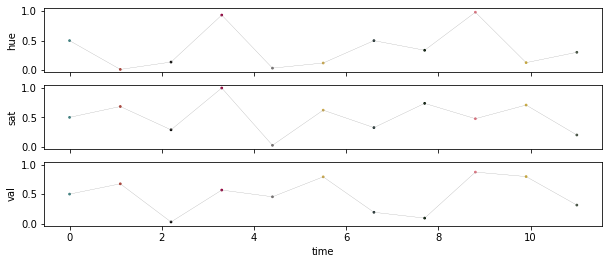

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,4), sharey=True)


#plot time course of H and color points by hsv
tt = np.linspace(0.0, len(colorcoordinates), len(colorcoordinates))
hue = colorcoordinates.transpose()[0]
sat = colorcoordinates.transpose()[1]
val = colorcoordinates.transpose()[2]

for ax in (ax1, ax2, ax3):
    ax.set(xlabel = "time")
    ax.label_outer()
    
ax1.scatter(tt, hue, c = rgb, s = 3)
ax1.plot(tt, hue, color = "grey", alpha = 1, linewidth = 0.2)
ax1.set(ylabel="hue")
ax2.scatter(tt, sat, c = rgb, s = 3)
ax2.plot(tt, sat, color = "grey", alpha = 1, linewidth = 0.2)
ax2.set(ylabel = "sat")
ax3.scatter(tt, val, c = rgb, s = 3)
ax3.plot(tt, val, color = "grey", alpha = 1, linewidth = 0.2)
ax3.set(ylabel = "val")


# plt.scatter(tt, hue, c = rgb)
# xlabel('hue', fontsize=16)
# ylabel('x', fontsize=16)
#grid(True)
plt.show()

Trying to animate using example from [here](https://medium.com/@pnpsegonne/animating-a-3d-scatterplot-with-matplotlib-ca4b676d4b55)


## create a data object that is a list of arrays
## each element in the list is the coordinates for the particle(s) at timen
[ (arr(p1t1),arr(p2t1),...),
(arr(p1t2),arr(p2,t2)...) ]

TODO:

1) add color to animation points  
2) allow multiple opoints to diffuse?  
3) tidy up code so that the animation can be called as a function  

In [183]:
res, disps = getHSVSteps(10,sigmasq = 0.01,startColor=np.array([0.5, 0.5, 0.5]))
#colorcoordinates = np.array([hh,ss,vv])
colorcoordinates=res.transpose()
rgb = colors.hsv_to_rgb(colorcoordinates)

In [184]:
# need to create a list of arrays of each element at each position to prepare function for animation
colorcoordinates
ll = []
for ii in colorcoordinates:
    jj = np.expand_dims(ii, 0)
    ll.append(jj)
codataani = ll

In [191]:
rgb

array([[0.25      , 0.5       , 0.5       ],
       [0.31184736, 0.47805801, 0.45975455],
       [0.26032089, 0.24472393, 0.39029769],
       [0.10373066, 0.12686309, 0.20865539],
       [0.10223798, 0.13728984, 0.18312456],
       [0.0257974 , 0.03475493, 0.04188475],
       [0.0548576 , 0.05742121, 0.07252729],
       [0.07226735, 0.08576315, 0.08868486],
       [0.04560401, 0.05403809, 0.06010368],
       [0.04983647, 0.08233846, 0.07800278],
       [0.14792724, 0.21160404, 0.19824731]])

In [199]:
hcol = []
for ii in range(len(rgb)):
    hcol.append((colors.to_hex(rgb[ii], keep_alpha=False)))
    

In [192]:
rgb.reshape(3,-1)

array([[0.25      , 0.5       , 0.5       , 0.31184736, 0.47805801,
        0.45975455, 0.26032089, 0.24472393, 0.39029769, 0.10373066,
        0.12686309],
       [0.20865539, 0.10223798, 0.13728984, 0.18312456, 0.0257974 ,
        0.03475493, 0.04188475, 0.0548576 , 0.05742121, 0.07252729,
        0.07226735],
       [0.08576315, 0.08868486, 0.04560401, 0.05403809, 0.06010368,
        0.04983647, 0.08233846, 0.07800278, 0.14792724, 0.21160404,
        0.19824731]])

In [188]:
for i in range(data[0].shape[0]):
    print(rgb[i])

[0.25 0.5  0.5 ]


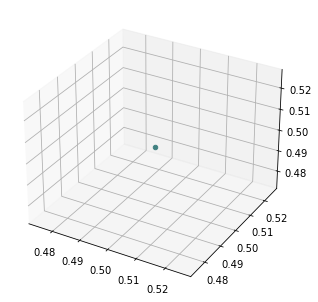

In [200]:
data = codataani

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)
# Initialize scatters
scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:], c=hcol[i]) for i in range(data[0].shape[0]) ]

In [201]:
save = True
# Number of iterations
iterations = len(data)

# Setting the axes properties
ax.set_xlim3d([0, 1])
ax.set_xlabel('Hue')

ax.set_ylim3d([0, 1])
ax.set_ylabel('Sat')

ax.set_zlim3d([0, 1])
ax.set_zlabel('Val')

ax.set_title('diffusion through hsv space')

# Provide starting angle for the view.
ax.view_init(25, 10)

ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                   interval=1000, blit=False, repeat=True)

if save:
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=3, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
    ani.save('color_diffusion.mp4', writer=writer)

plt.show()

In [130]:
"""
Generates dummy data.
The elements will be assigned random initial positions and speed.
Args:
    nbr_iterations (int): Number of iterations data needs to be generated for.
    nbr_elements (int): Number of elements (or points) that will move.
Returns:
    list: list of positions of elements. (Iterations x (# Elements x Dimensions))
"""

nbr_iterations = 10
nbr_elements = 1


dims = (3,1)

# Random initial positions.
gaussian_mean = np.zeros(dims)
gaussian_std = np.ones(dims)
start_positions = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T
# Random speed
start_speed = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T


In [131]:

# Computing trajectory
data = [start_positions]
for iteration in range(nbr_iterations):
    previous_positions = data[-1]
    new_positions = previous_positions + start_speed
    data.append(new_positions)

In [135]:
data

[array([[0.03763634, 0.66899303, 1.19619334]]),
 array([[-1.26135534,  0.07294999,  0.80332419]]),
 array([[-2.56034702, -0.52309306,  0.41045503]]),
 array([[-3.8593387 , -1.1191361 ,  0.01758588]]),
 array([[-5.15833038, -1.71517914, -0.37528328]]),
 array([[-6.45732206, -2.31122218, -0.76815243]]),
 array([[-7.75631374, -2.90726522, -1.16102159]]),
 array([[-9.05530542, -3.50330827, -1.55389074]]),
 array([[-10.3542971 ,  -4.09935131,  -1.9467599 ]]),
 array([[-11.65328878,  -4.69539435,  -2.33962905]]),
 array([[-12.95228046,  -5.29143739,  -2.73249821]])]

In [134]:
data[0].shape[0]

1

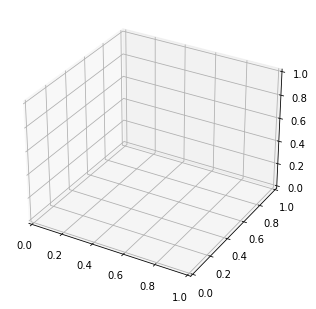

In [110]:
"""
Creates the 3D figure and animates it with the input data.

Args:
    data (list): List of the data positions at each iteration.
    save (bool): Whether to save the recording of the animation. (Default to False).
"""

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

In [111]:
# Initialize scatters
scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

In [124]:
save = True
# Number of iterations
iterations = len(data)

# Setting the axes properties
ax.set_xlim3d([-50, 50])
ax.set_xlabel('X')

ax.set_ylim3d([-50, 50])
ax.set_ylabel('Y')

ax.set_zlim3d([-50, 50])
ax.set_zlabel('Z')

ax.set_title('3D Animated Scatter Example')

# Provide starting angle for the view.
ax.view_init(25, 10)

ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                   interval=50, blit=False, repeat=True)

if save:
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
    ani.save('3d-scatted-animated.mp4', writer=writer)

plt.show()

In [100]:
def main(data, save=True):
    """
    Creates the 3D figure and animates it with the input data.

    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """

    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Initialize scatters
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

    # Number of iterations
    iterations = len(data)

    # Setting the axes properties
    ax.set_xlim3d([-50, 50])
    ax.set_xlabel('X')

    ax.set_ylim3d([-50, 50])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-50, 50])
    ax.set_zlabel('Z')

    ax.set_title('3D Animated Scatter Example')

    # Provide starting angle for the view.
    ax.view_init(25, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-scatted-animated.mp4', writer=writer)

    plt.show()

[array([[1.05446743, 1.84346362, 1.75817803]]),
 array([[0.78062528, 2.26386218, 2.71764823]]),
 array([[0.50678312, 2.68426075, 3.67711843]])]

In [96]:
def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.

    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)

    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

In [77]:

def generate_data(nbr_iterations, nbr_elements):
    """
    Generates dummy data.
    The elements will be assigned random initial positions and speed.
    Args:
        nbr_iterations (int): Number of iterations data needs to be generated for.
        nbr_elements (int): Number of elements (or points) that will move.
    Returns:
        list: list of positions of elements. (Iterations x (# Elements x Dimensions))
    """
    dims = (3,1)

    # Random initial positions.
    gaussian_mean = np.zeros(dims)
    gaussian_std = np.ones(dims)
    start_positions = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T

    # Random speed
    start_speed = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T

    # Computing trajectory
    data = [start_positions]
    for iteration in range(nbr_iterations):
        previous_positions = data[-1]
        new_positions = previous_positions + start_speed
        data.append(new_positions)

    return data



MovieWriter imagemagick unavailable; using Pillow instead.


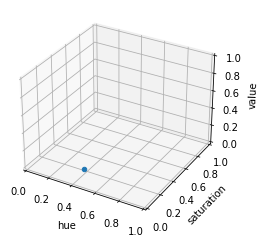

In [44]:
## 3d animation of single point
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
ax = fig.add_subplot(111, projection = '3d')
#ax.scatter(res[0], res[1], res[2], c = rgb)
ax.set_xlabel('hue')
ax.set_ylabel('saturation')
ax.set_zlabel('value')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

for ii in range(len(res[0])):
    #print(ii)
    ax.scatter(res[0][ii], res[1][ii], res[2][ii])
    camera.snap()
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')
animation



# rgb = colors.hsv_to_rgb(colorcoordinates)
# # C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# ax.scatter(res[0], res[1], res[2], c = rgb)
# ax.plot3D(res[0], res[1], res[2], 'grey', alpha = 0.25)
# ax.set_xlabel('hue')
# ax.set_ylabel('saturation')
# ax.set_zlabel('value')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
# plt.show()

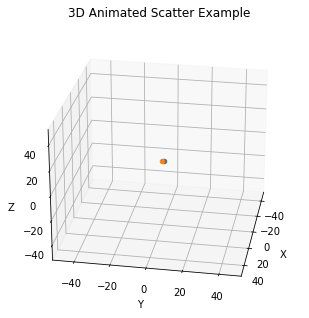

## trying to animate but not working

from this site

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


#line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line), interval=50, blit=False)



numDataPoints = len(hh)
dataSet = np.array([hh, ss, vv])
#dataSet = np.array([x, y, t])
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=0.5, c='g')[0]

redDots = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=2, c=colorcoordinates[0], marker='o')[0] # For scatter plot

# ANIMATION FUNCTION
def func(num, dataSet, line, redDots):
    # NOTE: there is no .set_data() for 3 dim data...
    #line.set_data(dataSet[0:2, :num])    
    line.set_3d_properties(dataSet[2, :num])    
    redDots.set_data(dataSet[0:2, :num])    
    redDots.set_3d_properties(dataSet[2, :num]) 
    return line
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line,redDots), interval=50, blit=False)
# line_ani.save(r'Animation.mp4')
 

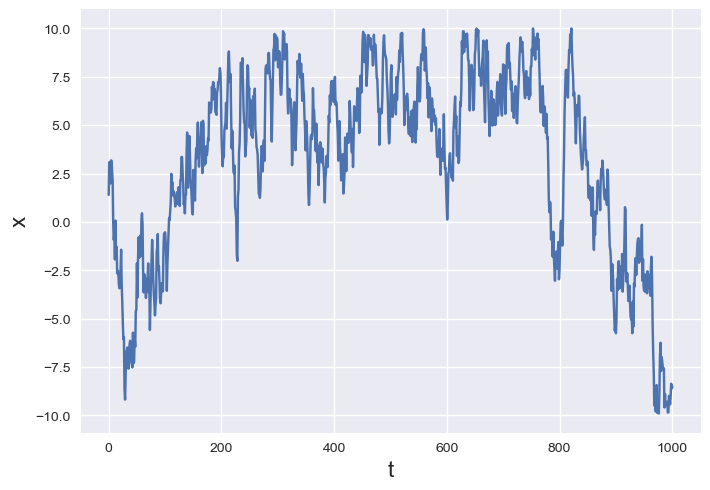

In [108]:
import numpy
from pylab import plot, show, grid, xlabel, ylabel

sigmasq = 1.0 # brownian rate

b = np.random.normal(size=1000, scale = np.sqrt(sigmasq))
bounded = cumsum_with_limits(b, 10, -10)
#print(bounded)
arr = numpy.array(bounded)
t = numpy.linspace(0.0, len(b), len(b))
plot(t, arr)
xlabel('t', fontsize=16)
ylabel('x', fontsize=16)
grid(True)
show()

In [68]:
res

array([[0.5       , 0.37373777, 0.91067308, 0.18400545, 0.91311609,
        0.00539549, 0.85771458, 0.83870932, 0.22245595, 0.63760531,
        0.63625682, 0.52094642, 0.50833756, 0.8476298 , 0.23783722,
        0.56006633, 0.78764672, 0.66425575, 0.61981202, 0.73282185,
        0.45033109, 0.52608326, 0.45449282, 0.99501729, 0.76622725,
        0.26755781, 0.92638161, 0.35924065, 0.96591379, 0.80798751,
        0.82279535, 0.30364032, 0.09737039, 0.58179653, 0.04722731,
        0.8568003 , 0.00642995, 0.10856327, 0.07444935, 0.48590014,
        0.7354869 , 0.74217326, 0.6510956 , 0.7420826 , 0.87037962,
        0.03401998, 0.67900054, 0.83268758, 0.33974261, 0.56666606,
        0.00100251, 0.68436256, 0.7765138 , 0.7867609 , 0.43148286,
        0.21564217, 0.44949175, 0.69703713, 0.23955825, 0.65814839,
        0.66416511, 0.99877081, 0.22695471, 0.42351583, 0.47740237,
        0.1909498 , 0.37958201, 0.43331145, 0.25114526, 0.32352988,
        0.63557332, 0.99117172, 0.42540268, 0.77

In [72]:
dd

[array([[-0.7625659 ,  0.57980296, -0.35502124]]),
 array([[-1.01530973,  1.70902672,  0.18223334]]),
 array([[-1.26805355,  2.83825049,  0.71948792]]),
 array([[-1.52079737,  3.96747425,  1.2567425 ]]),
 array([[-1.77354119,  5.09669801,  1.79399708]]),
 array([[-2.02628501,  6.22592178,  2.33125166]]),
 array([[-2.27902883,  7.35514554,  2.86850624]]),
 array([[-2.53177266,  8.4843693 ,  3.40576082]]),
 array([[-2.78451648,  9.61359307,  3.9430154 ]]),
 array([[-3.0372603 , 10.74281683,  4.48026997]]),
 array([[-3.29000412, 11.87204059,  5.01752455]])]

In [71]:
print(type(dd), type(res))
scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]
scatters[0]

<class 'list'> <class 'numpy.ndarray'>


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [64]:
animate_scatters(dd)

TypeError: animate_scatters() missing 2 required positional arguments: 'data' and 'scatters'

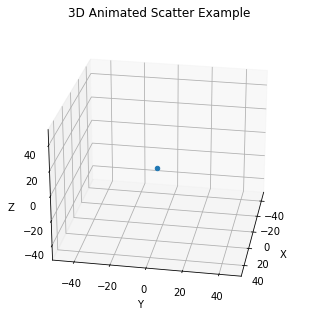

In [63]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def generate_data(nbr_iterations, nbr_elements):
    """
    Generates dummy data.
    The elements will be assigned random initial positions and speed.

    Args:
        nbr_iterations (int): Number of iterations data needs to be generated for.
        nbr_elements (int): Number of elements (or points) that will move.

    Returns:
        list: list of positions of elements. (Iterations x (# Elements x Dimensions))
    """
    dims = (3,1)

    # Random initial positions.
    gaussian_mean = np.zeros(dims)
    gaussian_std = np.ones(dims)
    start_positions = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T

    # Random speed
    start_speed = np.array(list(map(np.random.normal, gaussian_mean, gaussian_std, [nbr_elements] * dims[0]))).T

    # Computing trajectory
    data = [start_positions]
    for iteration in range(nbr_iterations):
        previous_positions = data[-1]
        new_positions = previous_positions + start_speed
        data.append(new_positions)

    return data

def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.

    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)

    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

def main(data, save=False):
    """
    Creates the 3D figure and animates it with the input data.

    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """

    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Initialize scatters
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

    # Number of iterations
    iterations = len(data)

    # Setting the axes properties
    ax.set_xlim3d([-50, 50])
    ax.set_xlabel('X')

    ax.set_ylim3d([-50, 50])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-50, 50])
    ax.set_zlabel('Z')

    ax.set_title('3D Animated Scatter Example')

    # Provide starting angle for the view.
    ax.view_init(25, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-scatted-animated.mp4', writer=writer)

    plt.show()


data = generate_data(10, 1)
main(data, save=True)

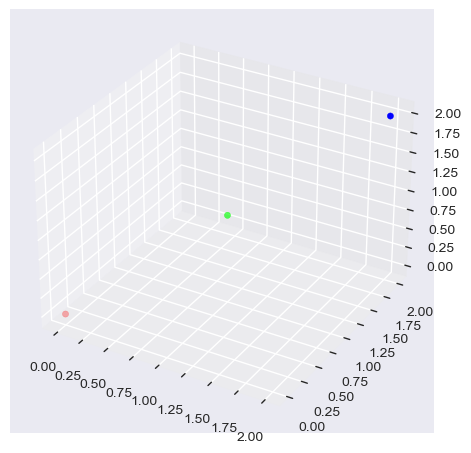

In [102]:
X = [0, 1, 2]
Y = [0, 1, 2]
Z = [0, 1, 2]
C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X, Y, Z, c = cc)
plt.show()

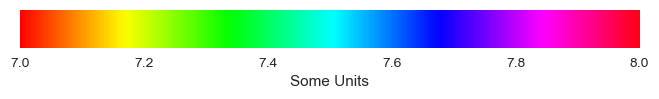

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=7, vmax=8)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units')

In [56]:
cmap = mpl.cm.hsv
cmap.N

256

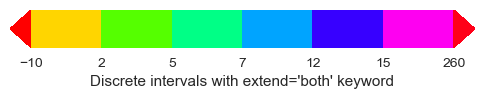

In [61]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.hsv
bounds = [-10, 2, 5, 7, 12, 15, 260]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

In [22]:
    n = 3
    
    from matplotlib import colors
    R = np.ones((1,n,3))
    R[0,:,0] = np.linspace(0, 1, n, endpoint=False)
    #Note: could iterate and use colorsys.hsv_to_rgb
    colors.hsv_to_rgb(R).squeeze() 

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
def main(imgsize):
    y, x = np.ogrid[6: -6: imgsize*2j, -6: 6: imgsize*2j]
    z = x + y*1j
    z = RiemannSphere(Klein(Mobius(Klein(z))))

    # define colors in hsv space
    H = np.sin(z[0]*np.pi)**2
    S = np.cos(z[1]*np.pi)**2
    V = abs(np.sin(z[2]*np.pi) * np.cos(z[2]*np.pi))**0.2
    HSV = np.stack((H, S, V), axis=2)

    # transform to rgb space
    img = hsv_to_rgb(HSV)
    fig = plt.figure(figsize=(imgsize/100.0, imgsize/100.0), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1], aspect=1)
    ax.axis('off')
    ax.imshow(img)
    fig.savefig('kaleidoscope.png')

main(100)

NameError: name 'RiemannSphere' is not defined

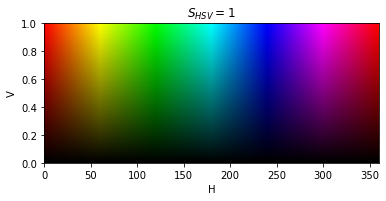

In [8]:
import numpy as np
import pylab as pl
from matplotlib.colors import hsv_to_rgb

V, H = np.mgrid[0:1:100j, 0:1:300j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)
pl.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=150)
pl.xlabel("H")
pl.ylabel("V")
pl.title("$S_{HSV}=1$")
pl.show()

In [16]:
V, H = np.mgrid[0:1:2j, 0:1:2j]

In [21]:
import matplotlib.pyplot as plt 
import numpy as np 
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        print(w)
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_HSV_normal(self,n_step=100):
        """
        Generate bounded brownian motion along three axes:
        H
        S
        V
        
        first lets try rescaling BM so it always lies between 0 and 1
        
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        print(w)
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s

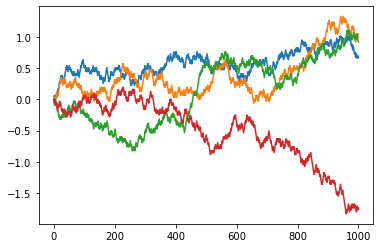

In [22]:
b = Brownian()
for i in range(4):
    plt.plot(b.gen_random_walk(1000))
plt.show()

In [32]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""

# File: brownian.py

from math import sqrt
from scipy.stats import norm
import numpy as np


def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

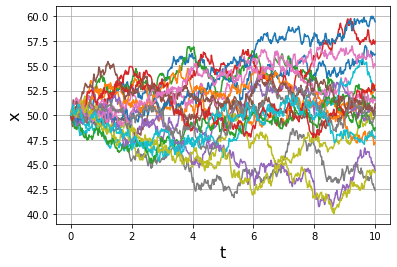

In [33]:
import numpy
from pylab import plot, show, grid, xlabel, ylabel

# The Wiener process parameter.
delta = 2
# Total time.
T = 10.0
# Number of steps.
N = 500
# Time step size
dt = T/N
# Number of realizations to generate.
m = 20
# Create an empty array to store the realizations.
x = numpy.empty((m,N+1))
# Initial values of x.
x[:, 0] = 50

brownian(x[:,0], N, dt, delta, out=x[:,1:])

t = numpy.linspace(0.0, N*dt, N+1)
for k in range(m):
    plot(t, x[k])
xlabel('t', fontsize=16)
ylabel('x', fontsize=16)
grid(True)
show()

In [80]:
# The Wiener process parameter.
sigma = 1
# Total time.
T = 10.0
# Number of steps.
N = 10
# Time step size
dt = T/N
# Number of realizations to generate.
m = 1
# Create an empty array to store the realizations.
x = numpy.empty((m,N+1))
# Initial values of x.
x[:, 0] = 0